# Importing libraries

In [1]:
from urllib.request import urlopen
import json
import pandas as pd
import numpy as np
import os
import time
from google.cloud import bigquery
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Fetching earthquake data from Data Warehouse

In [25]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'seismic-alert-system-cbd570f67095.json'
client = bigquery.Client()

sql_query = 'SELECT * FROM seismic-alert-system.seismic_datawarehouse.earthquake_deduped'

query_job = client.query(sql_query)

while query_job.state != 'DONE':
    query_job.reload()
    time.sleep(3)

if query_job.state == 'DONE':
    df = query_job.to_dataframe()
else:
    print(query_job.result())

In [74]:
df

,mag,depth,depth_class,mag_class,cluster
0,4.1,59.3,shallow,light,1
1,2.7,15.7,shallow,minor,0
2,4.3,58.6,shallow,light,1
3,4.1,33.0,shallow,light,1
4,3.0,40.4,shallow,minor,0
...,...,...,...,...,...
9995,5.3,44.0,shallow,moderate,1
9996,4.0,33.0,shallow,light,1
9997,4.4,35.0,shallow,light,1
9998,4.5,49.0,shallow,light,1


In [27]:
df = df.sample(n=10000)

In [84]:
df

,mag,depth
0,4.1,59.3
1,2.7,15.7
2,4.3,58.6
3,4.1,33.0
4,3.0,40.4
...,...,...
9995,5.3,44.0
9996,4.0,33.0
9997,4.4,35.0
9998,4.5,49.0


In [83]:
df.drop(columns=['depth_class'	,'mag_class'	,'cluster'], inplace=True)

C:\Users\Auli\AppData\Local\Temp\ipykernel_10972\1630046534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['depth_class'	,'mag_class'	,'cluster'], inplace=True)


In [67]:
df = df.tail(8000)

In [29]:
df[df.mag.isna()]

,time,place,mag,magType,depth,latitude,longitude
4012,1993-07-27 22:04:36.250,"15 km WNW of Miyako, Japan",NaN,None,88.1,39.713,141.785
10255,1990-08-16 00:38:22.980,"92 km W of Illapel, Chile",NaN,None,33.0,-31.525,-72.137
7417,1989-12-11 10:47:17.380,"38 km NNW of Valparaíso, Chile",NaN,None,10.0,-32.708,-71.772
10528,1987-05-10 07:10:46.510,"23 km SSE of San Antonio, Chile",NaN,None,10.0,-33.792,-71.529
9668,1985-01-11 19:38:16.290,"44 km W of Valparaíso, Chile",NaN,None,10.0,-33.013,-72.108
...,...,...,...,...,...,...,...
1671,1986-02-24 16:46:11.570,"31 km WNW of Chilecito, Argentina",NaN,None,140.0,-29.057,-67.8
2020,1985-02-22 19:49:36.790,"58 km WSW of Valparaíso, Chile",NaN,None,33.0,-33.168,-72.233
9891,1982-12-28 08:39:41.300,"149 km E of Iquique, Chile",NaN,None,147.6,-20.394,-68.732
67,1994-11-16 21:20:42.750,"59 km ENE of Machalí, Chile",NaN,None,5.0,-34.02,-70.034


In [30]:
df.mag.fillna(df.mag.mean(), inplace=True) # Filling the mag values with the mean of the field

In [51]:
df[df.place.str.contains('Japan')]

,time,place,mag,magType,depth,latitude,longitude
12161,2003-10-12 14:03:15.380,"197 km ESE of Ishinomaki, Japan",0.000000,None,33.00,37.523,143.243
44148,2012-02-11 19:55:51.400,"51 km SE of ?funato, Japan",4.900000,mb,57.80,38.692,142.054
78014,2011-03-23 00:06:43.490,"34 km ESE of Kamaishi, Japan",5.000000,mwc,40.70,39.206,142.254
81645,2004-07-27 08:44:16.730,"50 km SSW of Nemuro, Japan",4.600000,mwr,84.50,42.926,145.277
884,2002-03-19 15:17:43.090,"102 km ESE of Katsuura, Japan",4.053112,None,33.00,34.641,141.258
...,...,...,...,...,...,...,...
33006,2013-11-05 05:35:50.150,"185 km SSE of Katsuura, Japan",4.100000,mb,54.69,33.5644,140.9693
35434,2011-12-22 12:56:32.240,"120 km E of Miyako, Japan",4.600000,mb,37.80,39.78,143.337
51904,2011-03-13 22:49:35.970,"151 km ENE of Hasaki, Japan",4.700000,mb,11.30,36.297,142.359
83378,2022-05-09 08:33:07.436,"7 km NE of Toba, Japan",5.300000,mww,328.96,34.534,136.895


In [31]:
df_japan = df[df.place.str.contains('Japan')]
df = df[df.place.str.contains('Japan') == False]
depths = df_japan.depth.to_list()

In [32]:
def correct_depth(depths):
        corrected_depths = []
        for e in depths:
            if len(str(e)) >= 8:
                corrected_depth = str(e)[:3]
                corrected_depths.append(corrected_depth)
            else:
            #elif len(str(e)) >= 10:
                corrected_depth = str(e)[:2]
                corrected_depths.append(corrected_depth)
        return corrected_depths

In [33]:
df_japan.depth = correct_depth(depths)

C:\Users\Auli\AppData\Local\Temp\ipykernel_10972\3341205014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_japan.depth = correct_depth(depths)


In [34]:
df_japan.depth.max()

'99'

In [35]:
df = df.append(df_japan, ignore_index=True)
df

C:\Users\Auli\AppData\Local\Temp\ipykernel_10972\1640173126.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_japan, ignore_index=True)


,time,place,mag,magType,depth,latitude,longitude
0,2015-06-28 08:15:34.000,"38 km SSW of Diego de Almagro, Chile",4.100000,mb,59.3,-26.678,-70.215
1,2005-07-15 00:55:14.600,"67 km SE of Chimbarongo, Chile",2.700000,ml,15.7,-35.102,-70.474
2,2007-12-17 16:07:36.180,"78 km S of Tocopilla, Chile",4.300000,mb,58.6,-22.796,-70.222
3,1990-08-16 00:38:22.980,"92 km W of Illapel, Chile",4.063827,None,33.0,-31.525,-72.137
4,1998-08-19 17:17:36.800,"48 km SSW of Melipilla, Chile",3.000000,md,40.4,-34.066,-71.489
...,...,...,...,...,...,...,...
9995,1973-06-26 22:57:13.000,"104 km SE of Nemuro, Japan",5.300000,mb,44,42.801,146.641
9996,1997-10-25 13:14:30.310,"Izu Islands, Japan region",4.000000,mb,33,31.61,141.503
9997,2008-05-08 11:58:54.040,"101 km ENE of Hasaki, Japan",4.400000,mb,35,36.121,141.849
9998,1999-05-20 08:43:45.390,"179 km ENE of Miyako, Japan",4.500000,mb,49,40.416,143.794


In [36]:
df.depth = df.depth.astype(float)

In [85]:
conditions = [
    (df.depth >= -5 ) & (df.depth < 70),
    (df.depth >= 70 ) & (df.depth < 300),
    (df.depth >= 300)]
choices = ['shallow', 'intermediate', 'deep']
df['depth_class'] = np.select(conditions, choices)
df

C:\Users\Auli\AppData\Local\Temp\ipykernel_10972\3594118263.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depth_class'] = np.select(conditions, choices)


,mag,depth,depth_class
0,4.1,59.3,shallow
1,2.7,15.7,shallow
2,4.3,58.6,shallow
3,4.1,33.0,shallow
4,3.0,40.4,shallow
...,...,...,...
9995,5.3,44.0,shallow
9996,4.0,33.0,shallow
9997,4.4,35.0,shallow
9998,4.5,49.0,shallow


In [38]:
df[df.depth_class == '0']

,time,place,mag,magType,depth,latitude,longitude,depth_class


In [152]:
outlier_depth = df[df.depth_class == '0'].index
df.drop(outlier_depth, inplace=True)

In [86]:
conditions = [
    (df.mag >= -5 ) & (df.mag < 4.0),
    (df.mag >= 4.0 ) & (df.mag < 5.0),
    (df.mag >= 5.0 ) & (df.mag < 6.0),
    (df.mag >= 6.0 ) & (df.mag < 7.0),
    (df.mag >= 7.0 ) & (df.mag < 8.0),
    (df.mag >= 8.0 )]
choices = ['minor', 'light', 'moderate', 'strong', 'major', 'great']
df['mag_class'] = np.select(conditions, choices)
df

C:\Users\Auli\AppData\Local\Temp\ipykernel_10972\1106344970.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mag_class'] = np.select(conditions, choices)


,mag,depth,depth_class,mag_class
0,4.1,59.3,shallow,light
1,2.7,15.7,shallow,minor
2,4.3,58.6,shallow,light
3,4.1,33.0,shallow,light
4,3.0,40.4,shallow,minor
...,...,...,...,...
9995,5.3,44.0,shallow,moderate
9996,4.0,33.0,shallow,light
9997,4.4,35.0,shallow,light
9998,4.5,49.0,shallow,light


In [40]:
df[df.mag_class == '0']

,time,place,mag,magType,depth,latitude,longitude,depth_class,mag_class


In [112]:
outlier_mag = df[df.mag_class == 0].index
df.drop(outlier_mag, inplace=True)

# Defining features

We'll extract some features from the model, that being year, month and general location

In [4]:
df['year'] = df.time.dt.year # Creating a year feature
df['month'] = df.time.dt.month # Creating a month feature
df.drop(columns=['time', 'year'], inplace=True) 
df[['km', 'location']] = df['place'].str.split(',', 1, expand=True) # spliting the region from the aproximate location
df.location.fillna(df.km[df.km.str.contains('km') == False], inplace=True) # Filling the locations that didn't had km aproximations
no_location = df[df.location.isna()].index
df.drop(no_location, inplace=True)
df.drop(columns=['place'], inplace=True)

C:\Users\Auli\AppData\Local\Temp\ipykernel_5892\2334046914.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['km', 'location']] = df['place'].str.split(',', 1, expand=True) # spliting the region from the aproximate location


Features to use

In [41]:
df = df[['mag', 'depth', 'depth_class', 'mag_class']]

In [397]:
df[df.mag < 0]

,mag,depth,depth_class,mag_class


Replacing empty values and filling missing locations

In [10]:
df.location.replace(' ', '', inplace=True)
df.location.replace(' CA', 'California', inplace=True)
df.location.fillna(df.km[df.km.str.contains('km') == False], inplace=True)
no_location = df[df.location.isna()].index
df.drop(no_location, inplace=True)

In [11]:
df.location.isna().sum()*100/len(df)

0.0

In [12]:
df.drop(columns='km', inplace=True) # Dropping the 'km' field since it's not useful anymore

In [42]:
df.depth = df.depth.round(1) # Rounding the depth as to 1 decimal

C:\Users\Auli\AppData\Local\Temp\ipykernel_10972\2054496615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.depth = df.depth.round(1) # Rounding the depth as to 1 decimal


In [472]:
df

,mag,depth,depth_class,mag_class
0,3.4,70.0,intermidiate,minor
1,4.1,116.9,intermidiate,light
2,4.8,32.0,shallow,light
3,5.3,53.0,shallow,moderate
4,5.2,24.2,shallow,moderate
...,...,...,...,...
9995,4.0,26.0,shallow,light
9996,4.3,45.0,shallow,light
9997,5.1,39.0,shallow,moderate
9998,3.8,81.0,intermidiate,minor


In [400]:
depth_outlier = df[df.depth > 800].index
df.drop(depth_outlier, inplace=True)

C:\Users\Auli\AppData\Local\Temp\ipykernel_10872\2036848876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(depth_outlier, inplace=True)


Filling missing values

In [43]:
df.isna().sum()*100/len(df) # mag and magType have around %15 percent of missing values, since it's under the %25 percent, there'll be filled

mag            0.0
depth          0.0
depth_class    0.0
mag_class      0.0
dtype: float64

In [158]:
df.mag.fillna(df.mag.mean(), inplace=True) # Filling the mag values with the mean of the field
#df.magType.fillna(df.magType.mode()[0], inplace=True) # Filling the magType values with the mode

C:\Users\Auli\AppData\Local\Temp\ipykernel_6732\3337705884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.mag.fillna(df.mag.mean(), inplace=True) # Filling the mag values with the mean of the field


In [159]:
df.isna().sum()*100/len(df)

mag            0.0
depth          0.0
depth_class    0.0
dtype: float64

In [45]:
df

,mag,depth,depth_class,mag_class
0,4.1,59.3,shallow,light
1,2.7,15.7,shallow,minor
2,4.3,58.6,shallow,light
3,4.1,33.0,shallow,light
4,3.0,40.4,shallow,minor
...,...,...,...,...
9995,5.3,44.0,shallow,moderate
9996,4.0,33.0,shallow,light
9997,4.4,35.0,shallow,light
9998,4.5,49.0,shallow,light


In [44]:
df.mag = df.mag.round(1)

C:\Users\Auli\AppData\Local\Temp\ipykernel_10972\2097355316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.mag = df.mag.round(1)


# Machine learning process

## Trying to find the best features

Preprocessing

In [242]:
df.dtypes # We should encode the objects values and convert the coordinates to float

mag      float64
depth    float64
dtype: object

In [215]:
df.latitude = df.latitude.astype(float)
df.longitude = df.longitude.astype(float)

C:\Users\Auli\AppData\Local\Temp\ipykernel_9072\185884544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.latitude = df.latitude.astype(float)
C:\Users\Auli\AppData\Local\Temp\ipykernel_9072\185884544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.longitude = df.longitude.astype(float)


One hot encoding function

In [21]:
def one_hot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [87]:
data = one_hot_encode(df, ['depth_class', 'mag_class'], ['d_class', 'm_class'])
data # Encoded data

,mag,depth,d_class_deep,d_class_intermediate,d_class_shallow,m_class_light,m_class_major,m_class_minor,m_class_moderate,m_class_strong
0,4.1,59.3,0,0,1,1,0,0,0,0
1,2.7,15.7,0,0,1,0,0,1,0,0
2,4.3,58.6,0,0,1,1,0,0,0,0
3,4.1,33.0,0,0,1,1,0,0,0,0
4,3.0,40.4,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,5.3,44.0,0,0,1,0,0,0,1,0
9996,4.0,33.0,0,0,1,1,0,0,0,0
9997,4.4,35.0,0,0,1,1,0,0,0,0
9998,4.5,49.0,0,0,1,1,0,0,0,0


In [23]:
def complete_encoding(df):
        encoded_columns = ['d_class_deep', 'd_class_intermediate', 'd_class_shallow', 'm_class_great', 'm_class_light', 'm_class_major', 'm_class_minor', 'm_class_moderate', 'm_class_strong']
        for column in encoded_columns:
            if column not in df.columns:
                df[column] = 0
        return df

In [88]:
data = complete_encoding(data)

In [89]:
data

,mag,depth,d_class_deep,d_class_intermediate,d_class_shallow,m_class_light,m_class_major,m_class_minor,m_class_moderate,m_class_strong,m_class_great
0,4.1,59.3,0,0,1,1,0,0,0,0,0
1,2.7,15.7,0,0,1,0,0,1,0,0,0
2,4.3,58.6,0,0,1,1,0,0,0,0,0
3,4.1,33.0,0,0,1,1,0,0,0,0,0
4,3.0,40.4,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,5.3,44.0,0,0,1,0,0,0,1,0,0
9996,4.0,33.0,0,0,1,1,0,0,0,0,0
9997,4.4,35.0,0,0,1,1,0,0,0,0,0
9998,4.5,49.0,0,0,1,1,0,0,0,0,0


In [78]:
data.drop('cluster', axis=1, inplace=True)

In [6]:
df.m_class_major

0        0
1        0
2        0
3        0
4        0
        ..
84211    0
84212    0
84213    0
84214    0
84215    0
Name: m_class_major, Length: 84216, dtype: int64

In [164]:
data[data.m_class_0 == 1]

AttributeError: 'DataFrame' object has no attribute 'm_class_0'

# Fetching significant earthquake historical data

In [197]:
df_sig = pd.read_csv('Significant-Earthquake-Database.csv')

In [198]:
df_sig[df_sig['Focal Depth'].isna()] # The rows with no depth have no use for the model so we'll drop them

,ID,Date,Country,Location,Latitude,Longitude,Focal Depth,Class_Depth,Primary Magnitude,Class_Mag,Intensity,Deaths,Death Description,Damage (in M$),Damage Description,Houses Destroyed,Houses Destroyed Description,Houses Damaged,Houses Damaged Description,Tsunami
14,5950,NaN,JAPAN,"SEIONAIKAI, JAPAN",34.60,135.40,NaN,NaN,6.7,Strong,NaN,0.0,NaN,0.50,LIMITED (roughly corresponding to less than $1...,0.0,NaN,0.0,NaN,1.0
15,6019,NaN,JAPAN,"BOSO, JAPAN",35.20,140.60,NaN,NaN,6.7,Strong,NaN,0.0,NaN,0.00,NaN,0.0,NaN,0.0,NaN,1.0
16,1176,1707-10-28,JAPAN,JAPAN: ENSHUNADA,34.10,137.80,NaN,NaN,8.4,Great,NaN,0.0,NaN,0.00,NaN,0.0,NaN,0.0,NaN,1.0
17,1730,1829-09-26,CHILE,CHILE: VALPARAISO,-33.05,-71.63,NaN,NaN,7.0,Major,11.0,9.0,Few (~1 to 50 deaths),0.50,LIMITED (roughly corresponding to less than $1...,0.0,NaN,0.0,NaN,0.0
18,10008,1868-08-14,CHILE,CHILE: ARICA,-18.60,-71.00,NaN,NaN,8.5,Great,NaN,0.0,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,1315,1751-05-20,JAPAN,JAPAN: HONSHU: NW,37.20,138.10,NaN,NaN,6.6,Strong,NaN,2100.0,Very Many (~1001 or more deaths),4900.00,EXTREME (~$25 million or more),9100.0,Very Many (~1001 or more houses),0.0,NaN,1.0
576,1566,1804-07-10,JAPAN,JAPAN: KISAKATA,39.05,139.95,NaN,NaN,7.3,Major,NaN,450.0,Many (~101 to 1000 deaths),4900.00,EXTREME (~$25 million or more),10810.0,Very Many (~1001 or more houses),0.0,NaN,1.0
577,2195,1872-03-26,USA,CALIFORNIA: OWENS VALLEY,36.70,-118.10,NaN,NaN,7.8,Major,10.0,27.0,Few (~1 to 50 deaths),0.25,LIMITED (roughly corresponding to less than $1...,52.0,Some (~51 to 100 houses),0.0,NaN,1.0
580,2534,1898-04-22,JAPAN,JAPAN: SANRIKU,38.60,142.00,NaN,NaN,7.2,Major,NaN,0.0,NaN,11.00,SEVERE (~>$5 to $24 million),402.0,Many (~101 to 1000 houses),0.0,NaN,1.0


In [199]:
no_depth = df_sig[df_sig['Focal Depth'].isna()].index
df_sig.drop(no_depth, inplace=True)

In [200]:
df_sig = df_sig[['Primary Magnitude', 'Focal Depth']]

In [201]:
df_sig.rename(columns={'Primary Magnitude' : 'mag',
                        'Focal Depth' : 'depth'}, inplace=True)

In [202]:
df_sig

,mag,depth
0,6.6,39.0
1,6.1,7.0
2,6.0,6.0
3,6.1,9.0
4,6.3,11.0
...,...,...
589,5.3,14.0
590,6.8,39.0
591,7.6,19.0
592,8.3,22.0


# Merged Dataframe to use

In [203]:
df_merged = df.append(df_sig, ignore_index=True)
df_merged

C:\Users\Auli\AppData\Local\Temp\ipykernel_10872\2430071753.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merged = df.append(df_sig, ignore_index=True)


,mag,depth
0,4.9,34.2
1,4.6,35.0
2,3.4,114.0
3,2.9,56.9
4,4.9,35.0
...,...,...
2898,5.3,14.0
2899,6.8,39.0
2900,7.6,19.0
2901,8.3,22.0


# Scaling

In [90]:
X = data.copy()

In [91]:
X

,mag,depth,d_class_deep,d_class_intermediate,d_class_shallow,m_class_light,m_class_major,m_class_minor,m_class_moderate,m_class_strong,m_class_great
0,4.1,59.3,0,0,1,1,0,0,0,0,0
1,2.7,15.7,0,0,1,0,0,1,0,0,0
2,4.3,58.6,0,0,1,1,0,0,0,0,0
3,4.1,33.0,0,0,1,1,0,0,0,0,0
4,3.0,40.4,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,5.3,44.0,0,0,1,0,0,0,1,0,0
9996,4.0,33.0,0,0,1,1,0,0,0,0,0
9997,4.4,35.0,0,0,1,1,0,0,0,0,0
9998,4.5,49.0,0,0,1,1,0,0,0,0,0


In [92]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [93]:
X

,mag,depth,d_class_deep,d_class_intermediate,d_class_shallow,m_class_light,m_class_major,m_class_minor,m_class_moderate,m_class_strong,m_class_great
0,0.035587,0.344024,-0.017323,-0.525201,0.525665,0.787707,-0.026467,-0.645159,-0.294283,-0.093138,0.0
1,-1.557167,-0.802908,-0.017323,-0.525201,0.525665,-1.269507,-0.026467,1.550006,-0.294283,-0.093138,0.0
2,0.263123,0.325610,-0.017323,-0.525201,0.525665,0.787707,-0.026467,-0.645159,-0.294283,-0.093138,0.0
3,0.035587,-0.347818,-0.017323,-0.525201,0.525665,0.787707,-0.026467,-0.645159,-0.294283,-0.093138,0.0
4,-1.215862,-0.153155,-0.017323,-0.525201,0.525665,-1.269507,-0.026467,1.550006,-0.294283,-0.093138,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.400804,-0.058454,-0.017323,-0.525201,0.525665,-1.269507,-0.026467,-0.645159,3.398095,-0.093138,0.0
9996,-0.078181,-0.347818,-0.017323,-0.525201,0.525665,0.787707,-0.026467,-0.645159,-0.294283,-0.093138,0.0
9997,0.376891,-0.295206,-0.017323,-0.525201,0.525665,0.787707,-0.026467,-0.645159,-0.294283,-0.093138,0.0
9998,0.490659,0.073075,-0.017323,-0.525201,0.525665,0.787707,-0.026467,-0.645159,-0.294283,-0.093138,0.0


# Clustering

In [94]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

In [95]:
clusters = kmeans.predict(X)
clusters

array([1, 0, 1, ..., 1, 1, 0])

Visualization

In [96]:
pca = PCA(n_components=2)
reduced_X = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2'])
reduced_X

,PC1,PC2
0,-0.724245,0.571453
1,0.252651,-2.747277
2,-0.795985,0.672709
3,-1.055499,0.370379
4,0.469368,-2.398524
...,...,...
9995,-1.167790,0.337419
9996,-1.024037,0.317075
9997,-1.124693,0.545582
9998,-0.979822,0.705922


In [97]:
reduced_X['cluster'] = clusters
reduced_X

,PC1,PC2,cluster
0,-0.724245,0.571453,1
1,0.252651,-2.747277,0
2,-0.795985,0.672709,1
3,-1.055499,0.370379,1
4,0.469368,-2.398524,0
...,...,...,...
9995,-1.167790,0.337419,1
9996,-1.024037,0.317075,1
9997,-1.124693,0.545582,1
9998,-0.979822,0.705922,1


In [98]:
reduced_centers = pca.transform(kmeans.cluster_centers_)
reduced_centers

c:\Users\Auli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[ 0.26191908, -2.44443574],
       [-1.20183707,  0.46622622],
       [ 2.97283414,  1.04998861]])

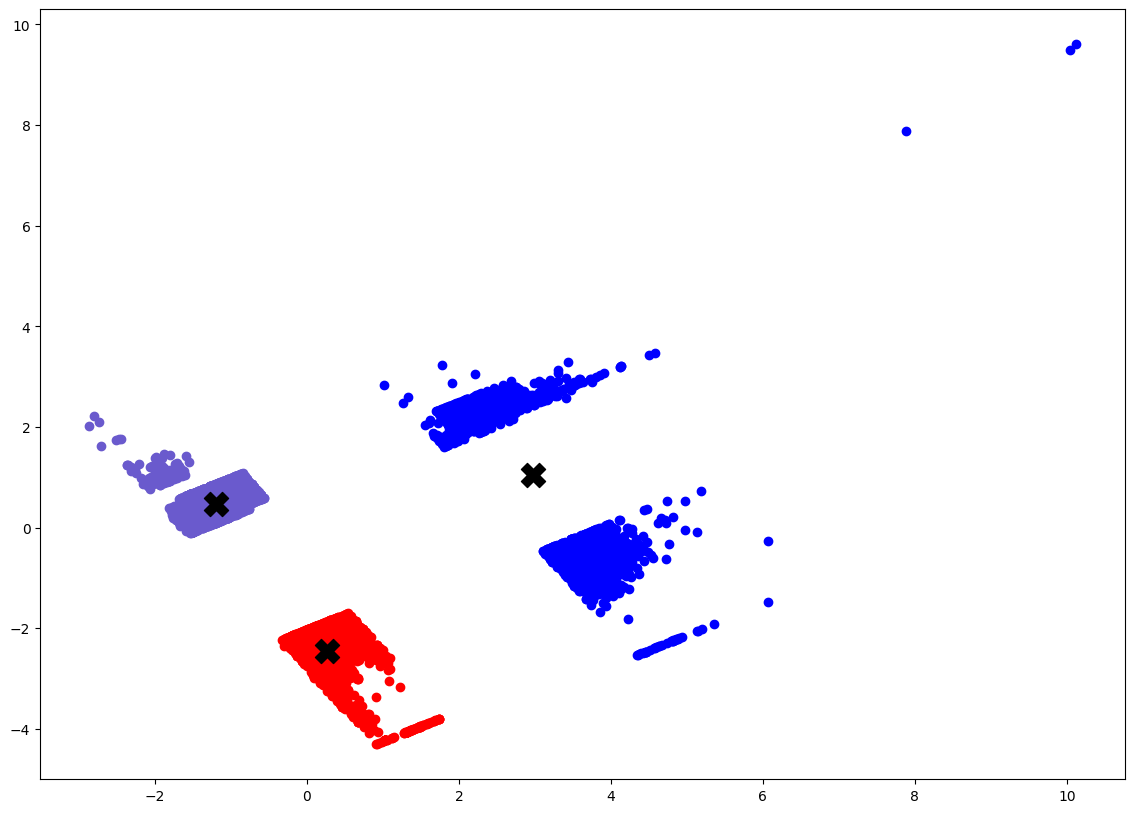

In [99]:
plt.figure(figsize=(14,10))

#plt.scatter(reduced_X.PC1, reduced_X.PC2)

plt.scatter(reduced_X[reduced_X.cluster == 1].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 1].loc[:, 'PC2'], color='slateblue')
plt.scatter(reduced_X[reduced_X.cluster == 0].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 0].loc[:, 'PC2'], color='red')
plt.scatter(reduced_X[reduced_X.cluster == 2].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 2].loc[:, 'PC2'], color='blue')
#plt.scatter(reduced_X[reduced_X.cluster == 3].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 3].loc[:, 'PC2'], color='indigo')
#plt.scatter(reduced_X[reduced_X.cluster == 4].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 4].loc[:, 'PC2'], color='teal')
#plt.scatter(reduced_X[reduced_X.cluster == 5].loc[:, 'PC1'], reduced_X[reduced_X.cluster == 5].loc[:, 'PC2'], color='red')


plt.scatter(reduced_centers[:,0], reduced_centers[:,1], color='black', marker='X', s=300)

plt.show()

In [100]:
kmeans.inertia_

56195.904989364295

In [101]:
k_rng = range(1,7)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
sse

[99999.99999999987,
 72340.42925878504,
 56195.904989364295,
 44198.12382425289,
 33567.885777778356,
 23208.026180105393]

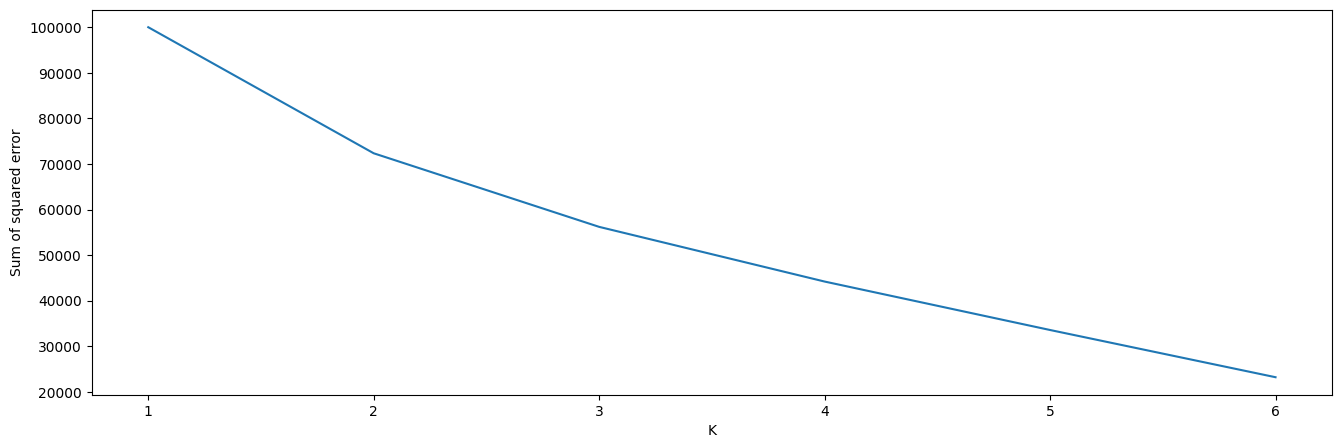

In [102]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng, sse)

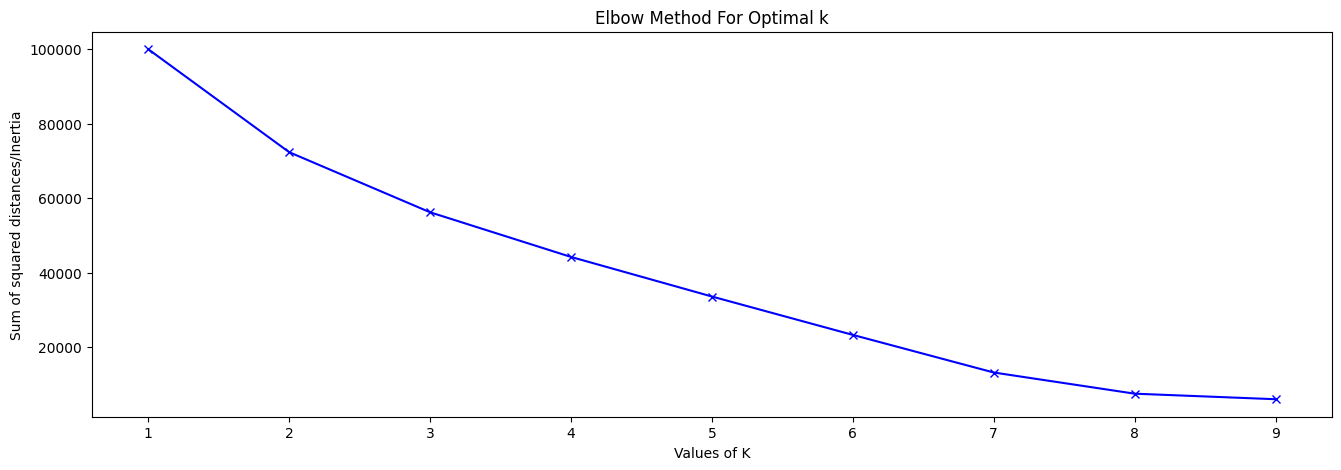

In [103]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

Saving model to see it perform with real time data

In [110]:
import joblib

joblib.dump(kmeans, 'KMeans_v9')

['KMeans_v9']

In [104]:
df['cluster'] = clusters

C:\Users\Auli\AppData\Local\Temp\ipykernel_10972\3381542803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = clusters


In [105]:
df

,mag,depth,depth_class,mag_class,cluster
0,4.1,59.3,shallow,light,1
1,2.7,15.7,shallow,minor,0
2,4.3,58.6,shallow,light,1
3,4.1,33.0,shallow,light,1
4,3.0,40.4,shallow,minor,0
...,...,...,...,...,...
9995,5.3,44.0,shallow,moderate,1
9996,4.0,33.0,shallow,light,1
9997,4.4,35.0,shallow,light,1
9998,4.5,49.0,shallow,light,1


In [106]:
print(f'0.0 cluster - Max mag: {df[df.cluster == 0.0].mag.max()}, min mag: {df[df.cluster == 0.0].mag.min()}')
print(f'1.0 cluster - Max mag: {df[df.cluster == 1.0].mag.max()}, min mag: {df[df.cluster == 1.0].mag.min()}')
print(f'2.0 cluster - Max mag: {df[df.cluster == 2.0].mag.max()}, min mag: {df[df.cluster == 2.0].mag.min()}')
#print(f'3.0 cluster - Max mag: {df[df.cluster == 3.0].mag.max()}, min mag: {df[df.cluster == 3.0].mag.min()}')
#print(f'4.0 cluster - Max mag: {df[df.cluster == 4.0].mag.max()}, min mag: {df[df.cluster == 4.0].mag.min()}')
#print(f'5.0 cluster - Max mag: {df[df.cluster == 5.0].mag.max()}, min mag: {df[df.cluster == 5.0].mag.min()}')

0.0 cluster - Max mag: 3.9, min mag: 0.0
1.0 cluster - Max mag: 7.9, min mag: 4.0
2.0 cluster - Max mag: 6.7, min mag: 0.0


In [107]:
print(f'0.0 cluster - Max depth: {df[df.cluster == 0.0].depth.max()}, min depth: {df[df.cluster == 0.0].depth.min()}')
print(f'1.0 cluster - Max depth: {df[df.cluster == 1.0].depth.max()}, min depth: {df[df.cluster == 1.0].depth.min()}')
print(f'2.0 cluster - Max depth: {df[df.cluster == 2.0].depth.max()}, min depth: {df[df.cluster == 2.0].depth.min()}')
#print(f'3.0 cluster - Max depth: {df[df.cluster == 3.0].depth.max()}, min depth: {df[df.cluster == 3.0].depth.min()}')
#print(f'4.0 cluster - Max depth: {df[df.cluster == 4.0].depth.max()}, min depth: {df[df.cluster == 4.0].depth.min()}')
#print(f'5.0 cluster - Max depth: {df[df.cluster == 5.0].depth.max()}, min depth: {df[df.cluster == 5.0].depth.min()}')

0.0 cluster - Max depth: 69.9, min depth: -3.7
1.0 cluster - Max depth: 69.9, min depth: 0.0
2.0 cluster - Max depth: 582.1, min depth: 70.0


In [111]:
print(df.mag.max())
print(df.mag.min())

7.9
0.0


In [108]:
df.cluster.value_counts()

1    5799
2    2165
0    2036
Name: cluster, dtype: int64

# Checking number of clusters

In [109]:
silhouette_score(X, kmeans.labels_)

0.7537228030668895

Creting list to see scores with different cluster number

In [69]:
k_means_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1,7)]

silhouette_scores = [silhouette_score(X, model.labels_) for model in k_means_per_k[1:]]

silhouette_scores

[0.5089209494754153,
 0.5613256936641317,
 0.6632543233006934,
 0.6904717624331486,
 0.6947088286833877]

Plotting silhouette scores

In [70]:
from pylab import rcParams

C:\Users\Auli\AppData\Local\Temp\ipykernel_10972\158933474.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(2,7), silhouette_scores, 'bo-', color='blue',


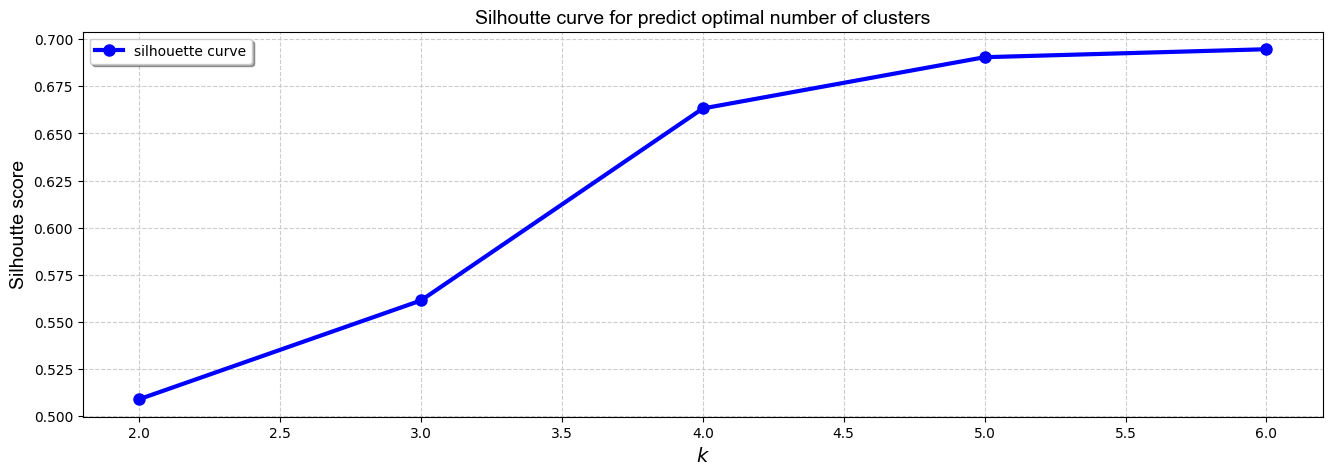

In [71]:
rcParams['figure.figsize'] = 16,5
plt.plot(range(2,7), silhouette_scores, 'bo-', color='blue',
linewidth=3, markersize=8, label='silhouette curve')
plt.xlabel('$k$', fontsize=14, family='Arial')
plt.ylabel('Silhoutte score', fontsize=14, family='Arial')
plt.grid(which='major', color='#cccccc', linestyle='--')

plt.title('Silhoutte curve for predict optimal number of clusters', family='Arial', fontsize=14)

k = np.argmax(silhouette_scores) * 2

plt.legend(shadow=True)

plt.show()